Load packages and start Matlab engine

In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.get_logger().setLevel('ERROR')

In [2]:
from tqdm import tqdm
from scipy import io as spio
import os
import sys
import numpy as np
import random as rnd
import traceback

seed = 42
np.random.seed(seed)
rnd.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)

import h5py
import matlab
import matlab.engine

import time
from datetime import timedelta

from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials
from hyperopt.pyll import scope
from hyperopt.fmin import generate_trials_to_calculate
from functools import reduce

from s2synth import rr_s2_data, mod_6_crop_s2_data
from sreval import rmse, sre, uiqi, ergas, sam, ssim
from sreval import sreval, evaluate_performance, dataframe_from_res_list

from mat_loaders import get_data

from S2_SSC_CNN.SSCwrap import SSCwrap

from boars import opt_method, data_list, meth_list, best_pars, get_method, pardict_to_matlist

import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial

In [3]:
# Set plot styles and size
%matplotlib inline
sns.set_style("ticks", rc={"axes.grid":True})
sns.set_context("paper", font_scale=2.5)
cmap = sns.color_palette('colorblind')

In [4]:
eng = matlab.engine.start_matlab()

Initialize parameters

In [5]:
max_evals = 150
metric = 'sre'
verbose = False
eval_bands=[2,6]
result_dir = './results/' + time.strftime("%Y%m%d%H%M")

In [6]:
for dataset in data_list:
    if dataset not in best_pars.keys(): best_pars[dataset] = {}
    # Make directory to save resullts
    os.makedirs(result_dir + '/' + dataset, exist_ok = True)

Find best parameters for S2 SSC

In [7]:
if 2 in eval_bands:
    method = SSCwrap
    SSCparameters = {'batch_size': ['int', 64, ('uniform_int', 16, 64)],
                     'lr': ['double', 0.0005, ('lognormal', np.exp(0.1), 0.5)],
                     'mtf_down': ['bool', True, ('choice', False, True)],
                     'ndown': ['int', 3, ('constant')],
                     'num_epochs': ['int', 200, ('constant')],
                     'verbose': ['string', False, ('constant')]}

    for dataset in data_list:
        try:
            print('Tuning S2 SSC parameters for', dataset)
            SSCpars = opt_method(method, SSCparameters, max_evals, dataset=dataset, metric=metric, eval_bands=[2], verbose=True, matlab_func=False, savefile=result_dir + '/' + dataset + '/' + 'SSC')
            best_pars[dataset]['SSC'] = SSCpars
            best_pars[dataset]['SSC']['batch_size'] = int(best_pars[dataset]['SSC']['batch_size'])
            best_pars[dataset]['SSC']['mtf_down'] = bool(best_pars[dataset]['SSC']['mtf_down'])
        except:
            if verbose: traceback.print_exc()
            print('Parameter tuning for S2 SSC failed!')

Tuning S2 SSC parameters for rkvik


/home/sveinn/miniconda3/envs/S2srdemo/lib/python3.7/site-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


151trial [45:38, 18.13s/trial, best loss: -20.920911115490256]                       
pars:
 {'batch_size': 18, 'lr': 0.0002534236661883235, 'mtf_down': True, 'ndown': 3, 'num_epochs': 200, 'verbose': False}
best sre : -20.920911115490256
Tuning S2 SSC parameters for escondido
151trial [31:43, 12.61s/trial, best loss: -30.379014385779595]                      
pars:
 {'batch_size': 18, 'lr': 0.00044435684780825256, 'mtf_down': True, 'ndown': 3, 'num_epochs': 200, 'verbose': False}
best sre : -30.379014385779595
Tuning S2 SSC parameters for aviris
151trial [30:45, 12.22s/trial, best loss: -35.1430203302582]                       
pars:
 {'batch_size': 16, 'lr': 0.0006767853816676112, 'mtf_down': True, 'ndown': 3, 'num_epochs': 200, 'verbose': False}
best sre : -35.1430203302582


Find best parameters for S2Sharp

In [8]:
eng.addpath('./S2Sharp')
S2sharpwrap = eng.S2sharpwrap
method = S2sharpwrap
S2sharpparameters = {'r': ['int', 8, ('uniform_int', 5, 9)], 
              'q1': ['double', 1, ('lognormal', 0, 0.5)], 
              'q2': ['double', 0.3851, ('lognormal', 0, 0.5)], 
              'q3': ['double', 6.9039, ('lognormal', 0, 0.5)], 
              'q4': ['double', 19.9581, ('lognormal', 0, 0.5)], 
              'q5': ['double', 47.8967, ('lognormal', 0, 0.5)], 
              'q6': ['double', 27.5518, ('lognormal', 0, 0.5)], 
              'q7': ['double', 2.7100, ('lognormal', 0, 0.5)], 
              'q8': ['double', 34.8689, ('lognormal', 0, 0.5)], 
              'q9': ['double', 1, ('lognormal', 0, 0.5)], 
              'q10': ['double', 1, ('lognormal', 0, 0.5)], 
              'lam': ['double', 1.8998e-04, ('lognormal', np.exp(0.005), 0.5)]}


In [9]:
for dataset in data_list:
    try:
        print('Tuning S2Sharp parameters for', dataset)
        S2sharppars = opt_method(method, S2sharpparameters, max_evals, dataset=dataset, metric='sre', eval_bands=eval_bands, verbose=True, savefile=result_dir + '/' + dataset + '/' + 'S2sharp')
        best_pars[dataset]['S2Sharp'] = S2sharppars
        best_pars[dataset]['S2Sharp']['r'] = int(best_pars[dataset]['S2Sharp']['r'])
    except:
        if verbose: traceback.print_exc()
        print('Parameter tuning for S2Sharp failed!')

Tuning S2Sharp parameters for rkvik
151trial [8:24:51, 200.60s/trial, best loss: -19.106608244459476]                        
pars:
 {'lam': 0.9524907551736812, 'q1': 5.43455894447927e-05, 'q10': 376.13461986972135, 'q2': 0.030841154246573008, 'q3': 0.8427700364789719, 'q4': 0.17389918921672023, 'q5': 4.6730600700514895, 'q6': 77683.56506435938, 'q7': 0.21432843535046803, 'q8': 0.8034008292419502, 'q9': 1.0351207925598362, 'r': 9}
best sre : -19.106608244459476
Tuning S2Sharp parameters for escondido
151trial [2:14:06, 53.29s/trial, best loss: -30.41599019803318]                         
pars:
 {'lam': 1.4095245395362919, 'q1': 0.14138976342320173, 'q10': 1.8990536279028118, 'q2': 0.013467237183886932, 'q3': 0.6194489935513873, 'q4': 2.289346931099906, 'q5': 33939.524104725984, 'q6': 1.1080519587865163, 'q7': 0.37579563139350125, 'q8': 0.8842577508469299, 'q9': 151.02823595348912, 'r': 5}
best sre : -30.41599019803318
Tuning S2Sharp parameters for aviris
151trial [59:22, 23.60s/trial, 

## Once code has been placed in appropriate folders change the following cells from raw to code in order to run.

Find best parameters for ATPRK

Find best parameters for SSSS

Find best parameters for SupReME

Find best parameters for MuSA

Display the best parameters, copy results into `boars.py` to update

In [10]:
import json
print('best_pars =', json.dumps(best_pars, sort_keys=True, indent=4).replace("true","True").replace("false","False"))

best_pars = {
    "apex": {
        "ATPRK": {
            "H": 11.0,
            "L_range": 17.0,
            "L_sill": 13.0,
            "Range_min": 0.9295475471200471,
            "Sill_min": 2.0,
            "rate": 1.1093648601650439
        },
        "MuSA": {
            "lam": 0.0005075231839284101,
            "mu": 0.21136587946368565
        },
        "S2Sharp": {
            "lam": 1.9341127858603557,
            "q1": 0.006073349262165454,
            "q10": 0.47647853130518464,
            "q2": 7.208822829845069e-05,
            "q3": 0.10893797078726071,
            "q4": 1.135516401017811,
            "q5": 14.103620956839348,
            "q6": 25.39252883568256,
            "q7": 0.9735978109673542,
            "q8": 66.43736365056141,
            "q9": 3.2947729421976493,
            "r": 9.0
        },
        "SSC": {
            "batch_size": 63,
            "lr": 0.0005153685695537464,
            "mtf_down": True
        },
        "SSSS": {
            "lam"

Run methods with best parameters and compare.

In [13]:
multi_run=False
verbose=True
limsub = 6
eval_bands=None
eval_dfs = {}
Yims = {}
Xm_ims = {}
Xhats = {}

band_scales = np.array([6, 1, 1, 1, 2, 2, 2, 1, 2, 6, 2, 2])
band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
band_idxs = {'B1':0, 'B2':1, 'B3':2, 'B4':3, 'B5':4, 'B6':5, 'B7':6, 'B8':7, 'B8A':8, 'B9':9, 'B11':10, 'B12':11}

for dataset in data_list:
    #Load data
    (Yim, Xm_im, eval_bands) = get_data(dataset, datadir='./data/')
    (Yim, mtf) = get_data(dataset, datadir='./data/', get_mtf=True)[:2]
    # Format for matlab methods
    mYim = [matlab.double(b.tolist()) for b in Yim]
    mXm_im =[]
    for b in range(Xm_im.shape[-1]):
        mXm_im.append(matlab.double(Xm_im[:,:,b].tolist()))
    mXm_im = matlab.double(mXm_im)
    mXm_im = eng.permute(mXm_im, matlab.int16([2,3,1]))
    Yims[dataset] = Yim
    Xm_ims[dataset] = Xm_im
    Xhats[dataset] = {}
    for meth_name in meth_list:
        try:
            if verbose: print('Processing', dataset, 'with', meth_name, '!')
            method = get_method(meth_name, matlab_handle=eng)
            pars = best_pars.get(dataset, best_pars['default']).get(meth_name, {})
            if meth_name is 'SSC' or meth_name is 'DSen2':
                Xhat = method(Yim, **pars)
            else:
                Xhat = np.array(method(mYim, *pardict_to_matlist(pars)))
            Xhats[dataset][meth_name] = Xhat
            if verbose: print(meth_name, 'done!')
        except:
            if verbose: traceback.print_exc()
            print(meth_name, 'failed!')
    np.savez_compressed(result_dir + '/' + dataset + '/srdata.npz', **Xhats[dataset])
    if eval_bands is not None:
        res_list = sreval(Xm_im, Xhats[dataset].values(), limsub=limsub, bands=eval_bands)
        evals_df = dataframe_from_res_list(res_list, Xhats[dataset].keys(), band_idxs, multi_run=multi_run)
        evals_df = evals_df.drop(['B2','B3','B4','B8'], level=1)
        if 2 not in eval_bands:
            evals_df = evals_df.drop(['B5','B6','B7','B8A', 'B11', 'B12','20m','All'], level=1)
        if 6 not in eval_bands:
            evals_df = evals_df.drop(['B1','B9','60m','All'], level=1)
        evals_df.to_csv(result_dir + '/' + dataset + '/tuned_comparison.csv',sep='\t',decimal='.')
        evals_df.to_hdf(result_dir + '/' + dataset + '/tuned_comparison_dataframe.h5', key=dataset)
        eval_dfs[dataset] = evals_df

Processing rkvik with S2Sharp !
S2Sharp done!
Processing rkvik with SSC !
SSC done!
Processing escondido with S2Sharp !
S2Sharp done!
Processing escondido with SSC !
SSC done!
Processing aviris with S2Sharp !
S2Sharp done!
Processing aviris with SSC !
SSC done!


Display results.

Input B1


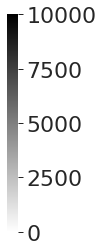

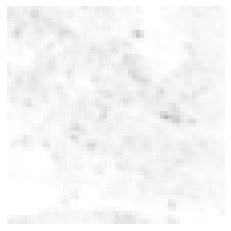

Ground truth
NaN
Input zoom


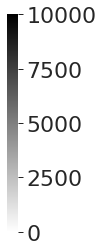

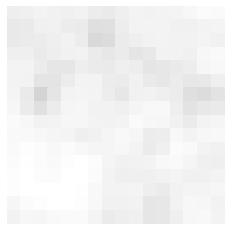

Ground truth zoom
NaN
B1 S2Sharp


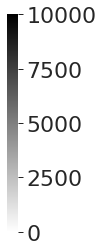

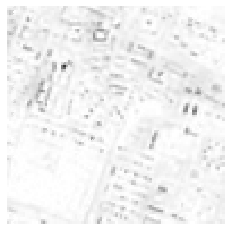

B1 SSC
NaN
Input B5


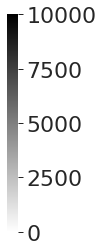

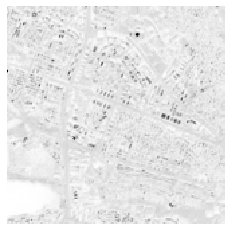

Ground truth
NaN
Input zoom


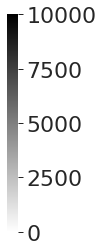

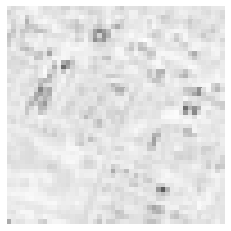

Ground truth zoom
NaN
B5 S2Sharp


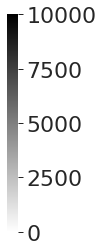

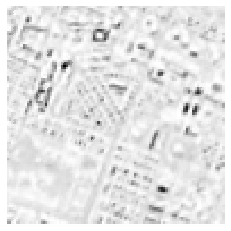

B5 SSC


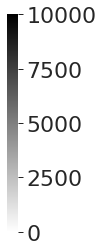

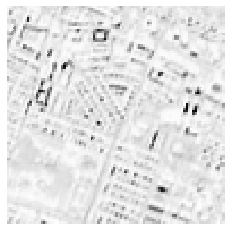

Input B6


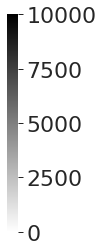

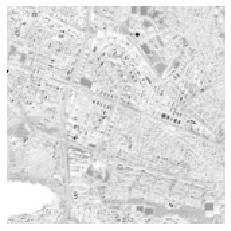

Ground truth
NaN
Input zoom


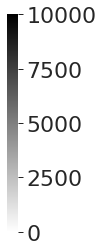

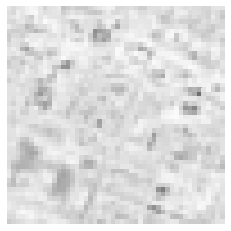

Ground truth zoom
NaN
B6 S2Sharp


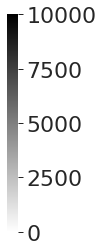

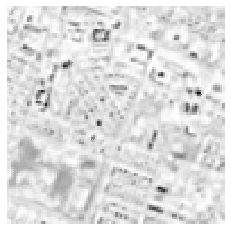

B6 SSC


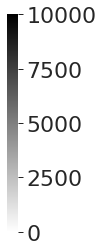

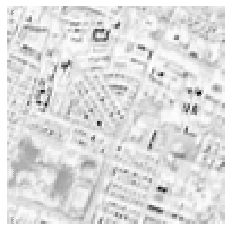

Input B7


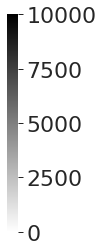

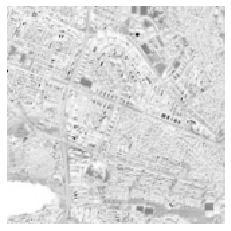

Ground truth
NaN
Input zoom


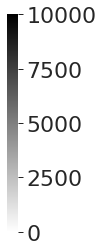

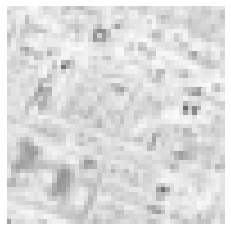

Ground truth zoom
NaN
B7 S2Sharp


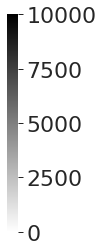

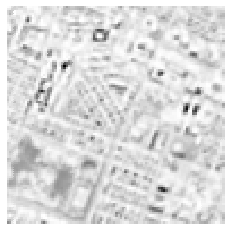

B7 SSC


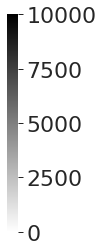

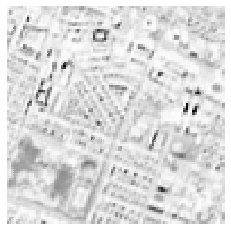

Input B8A


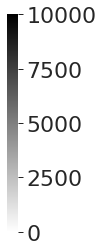

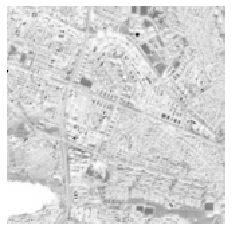

Ground truth
NaN
Input zoom


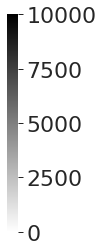

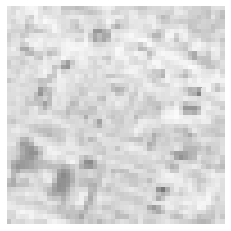

Ground truth zoom
NaN
B8A S2Sharp


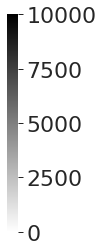

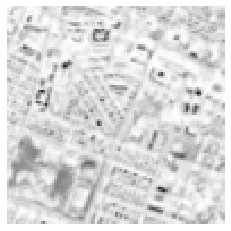

B8A SSC


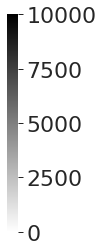

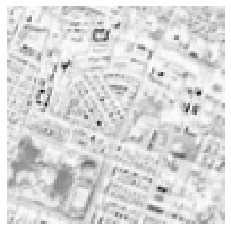

Input B9


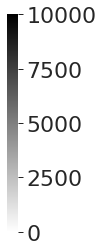

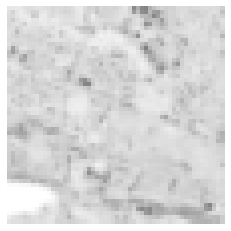

Ground truth
NaN
Input zoom


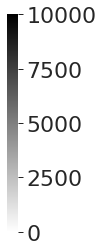

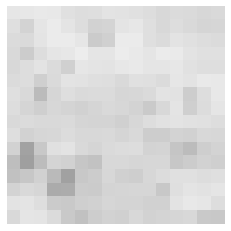

Ground truth zoom
NaN
B9 S2Sharp


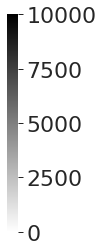

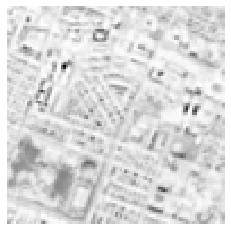

B9 SSC
NaN
Input B11


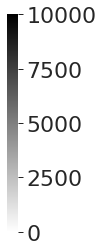

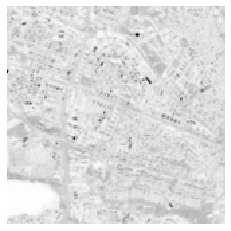

Ground truth
NaN
Input zoom


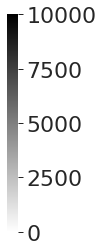

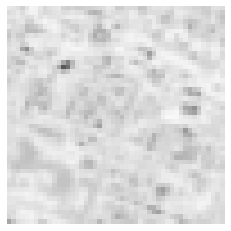

Ground truth zoom
NaN
B11 S2Sharp


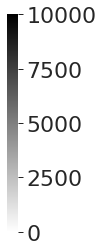

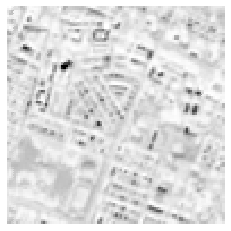

B11 SSC


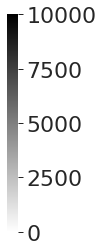

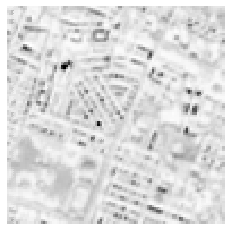

Input B12


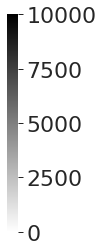

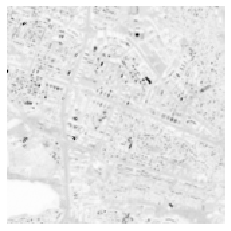

Ground truth
NaN
Input zoom


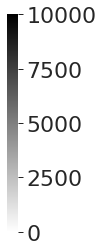

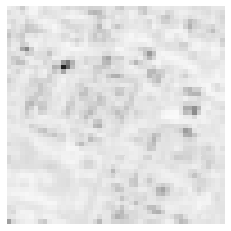

Ground truth zoom
NaN
B12 S2Sharp


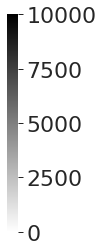

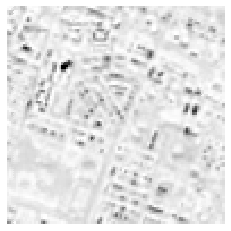

B12 SSC


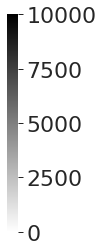

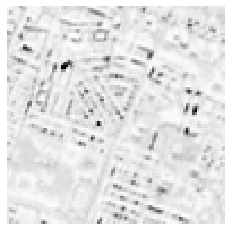

Input B1


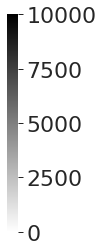

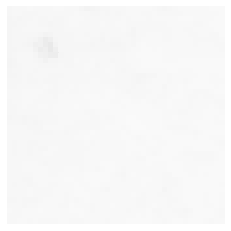

Ground truth


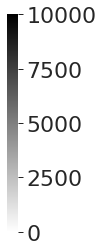

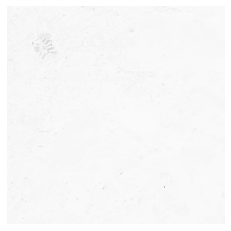

Input zoom


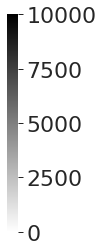

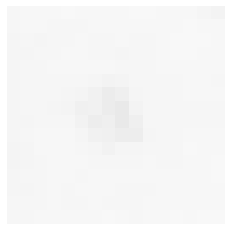

Ground truth zoom


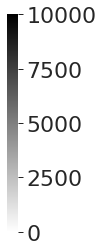

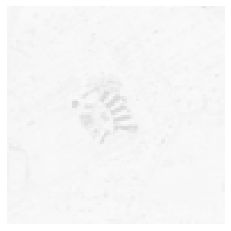

B1 S2Sharp


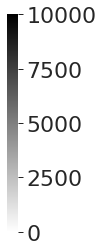

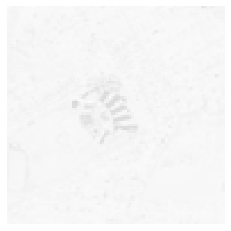

B1 SSC
NaN
Input B5


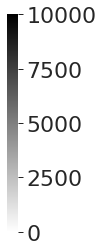

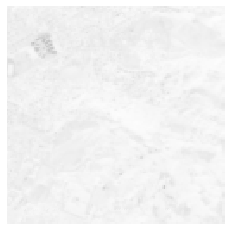

Ground truth


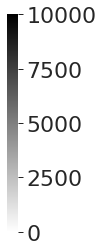

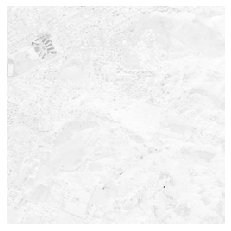

Input zoom


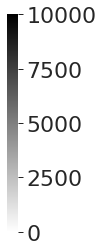

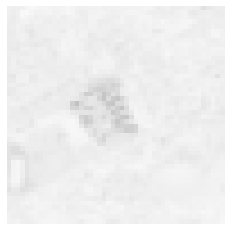

Ground truth zoom


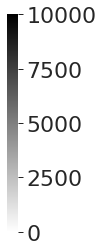

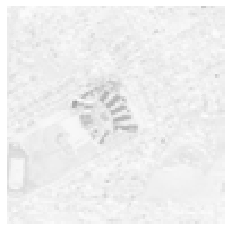

B5 S2Sharp


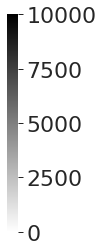

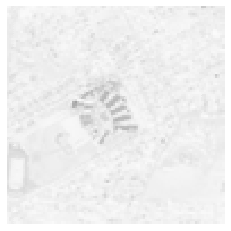

B5 SSC


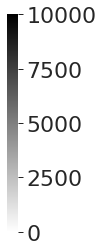

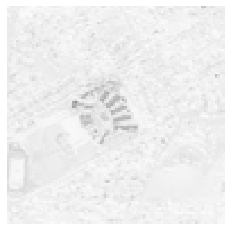

Input B6


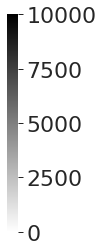

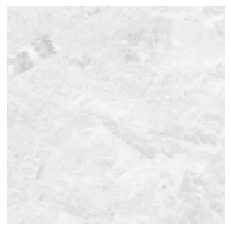

Ground truth


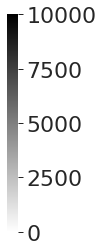

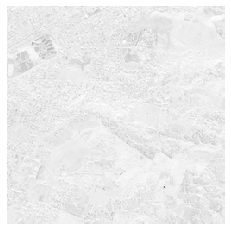

Input zoom


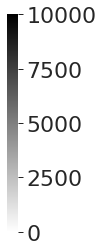

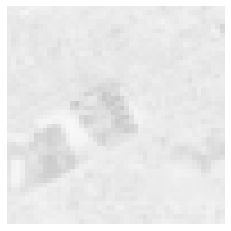

Ground truth zoom


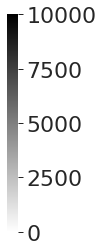

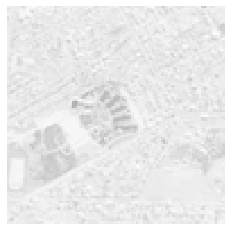

B6 S2Sharp


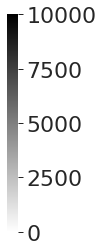

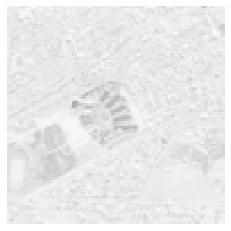

B6 SSC


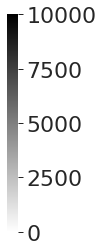

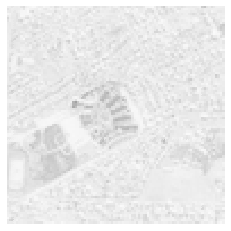

Input B7


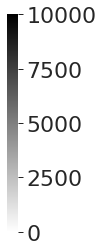

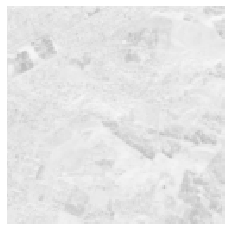

Ground truth


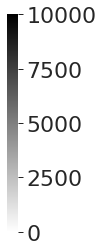

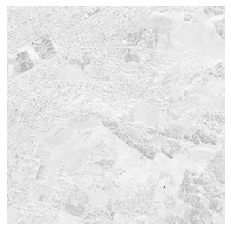

Input zoom


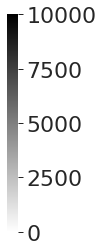

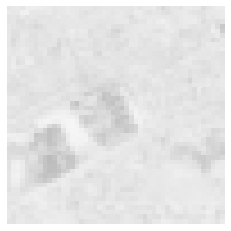

Ground truth zoom


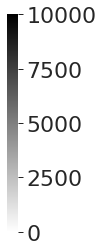

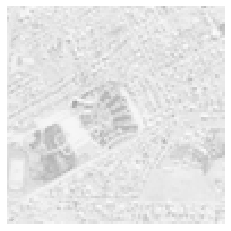

B7 S2Sharp


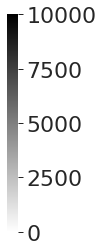

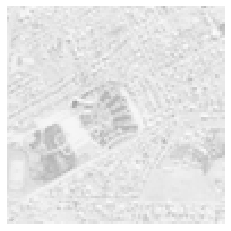

B7 SSC


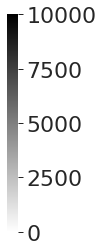

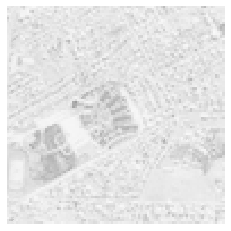

Input B8A


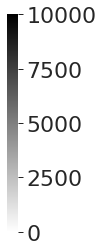

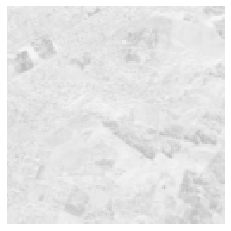

Ground truth


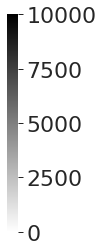

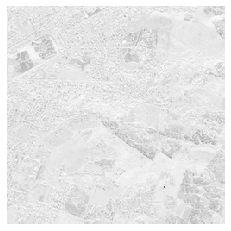

Input zoom


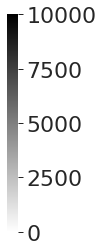

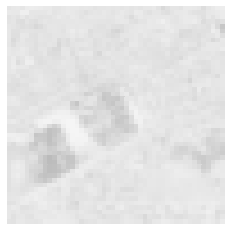

Ground truth zoom


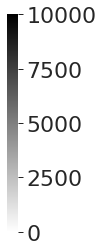

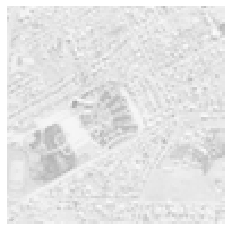

B8A S2Sharp


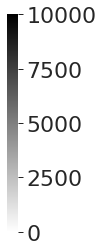

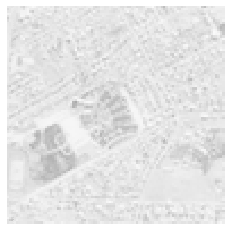

B8A SSC


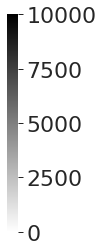

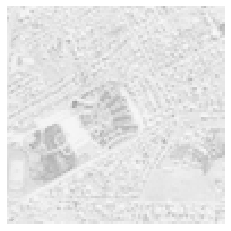

Input B9


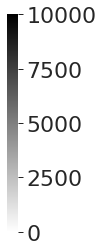

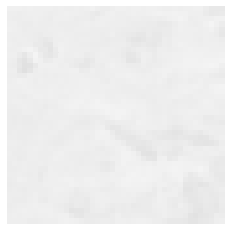

Ground truth


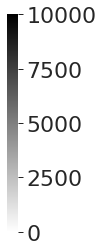

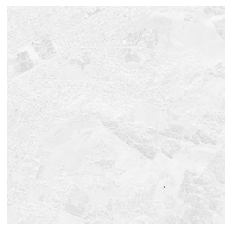

Input zoom


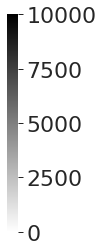

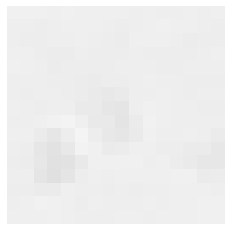

Ground truth zoom


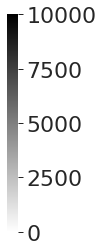

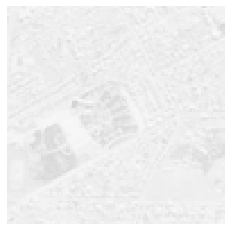

B9 S2Sharp


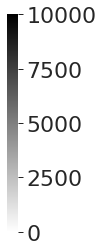

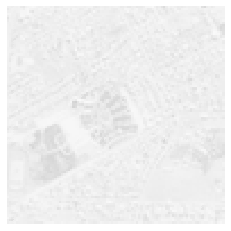

B9 SSC
NaN
Input B11


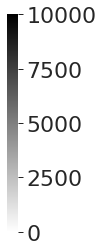

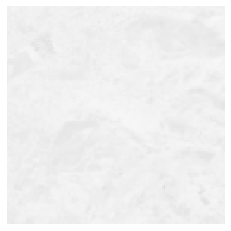

Ground truth


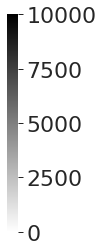

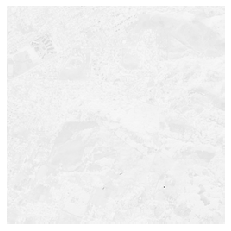

Input zoom


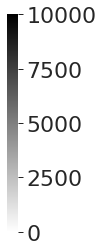

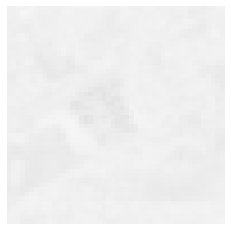

Ground truth zoom


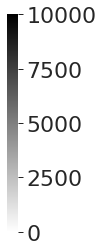

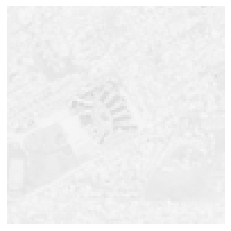

B11 S2Sharp


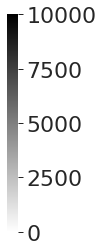

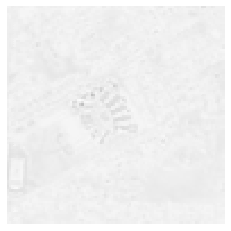

B11 SSC


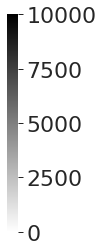

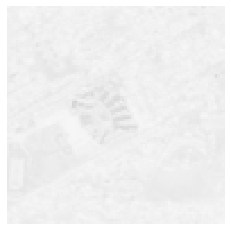

Input B12


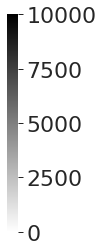

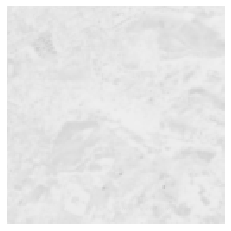

Ground truth


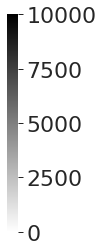

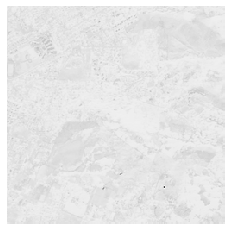

Input zoom


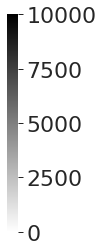

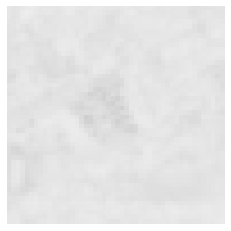

Ground truth zoom


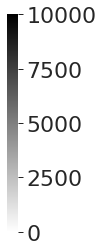

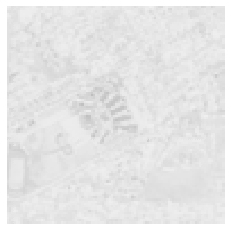

B12 S2Sharp


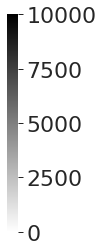

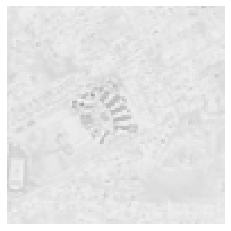

B12 SSC


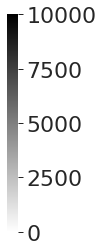

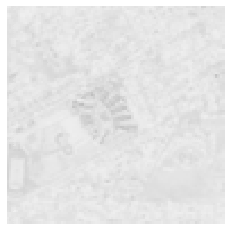

Input B1


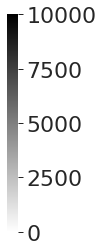

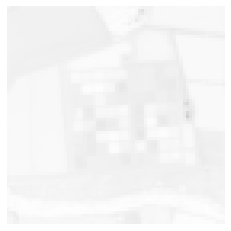

Ground truth


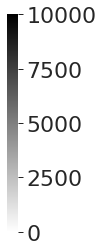

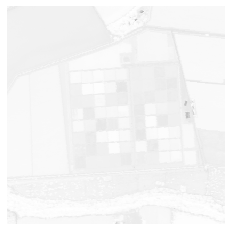

Input zoom


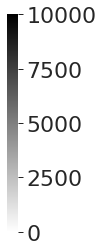

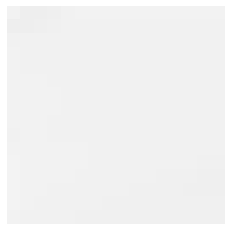

Ground truth zoom


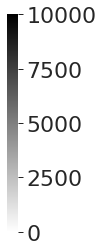

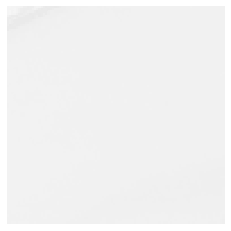

B1 S2Sharp


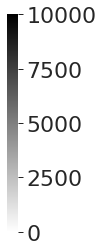

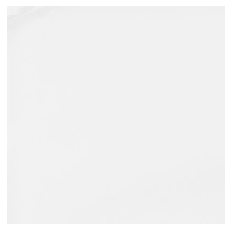

B1 SSC
NaN
Input B5


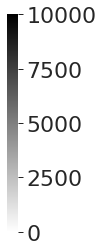

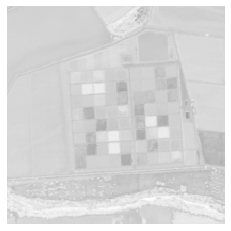

Ground truth


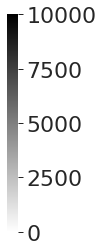

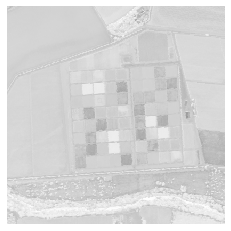

Input zoom


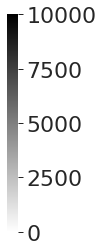

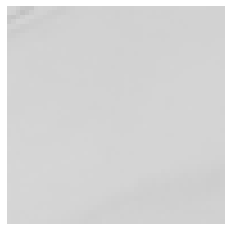

Ground truth zoom


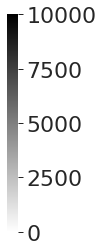

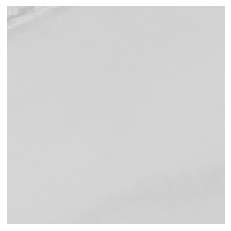

B5 S2Sharp


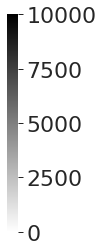

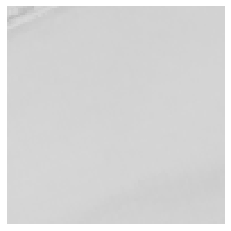

B5 SSC


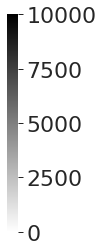

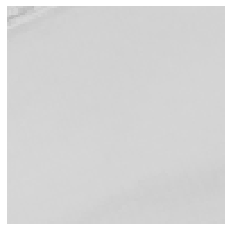

Input B6


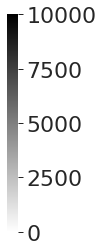

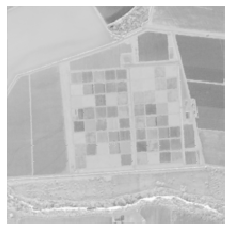

Ground truth


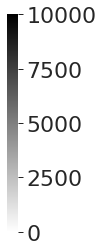

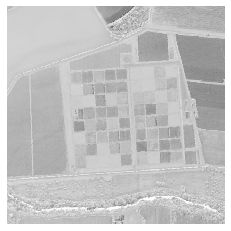

Input zoom


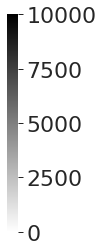

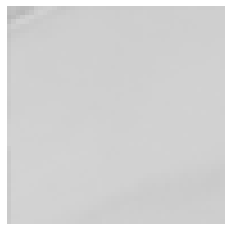

Ground truth zoom


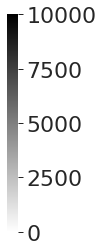

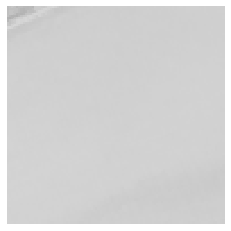

B6 S2Sharp


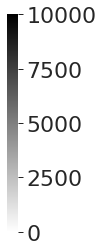

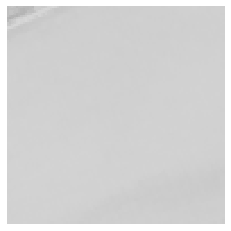

B6 SSC


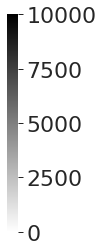

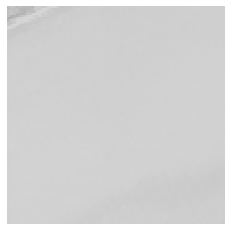

Input B7


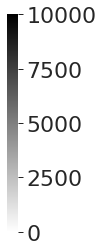

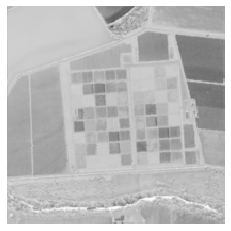

Ground truth


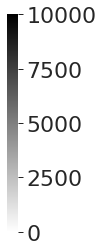

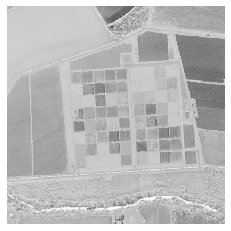

Input zoom


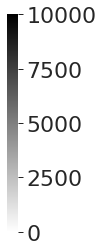

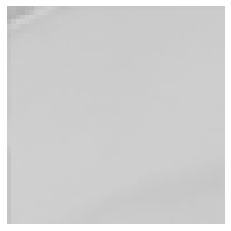

Ground truth zoom


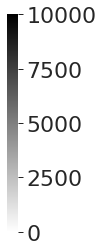

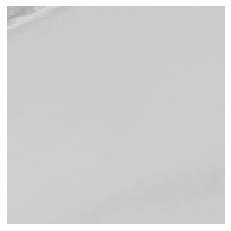

B7 S2Sharp


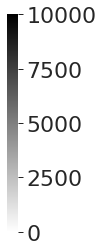

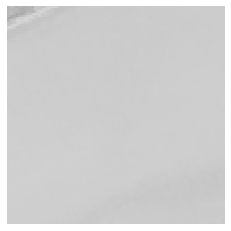

B7 SSC


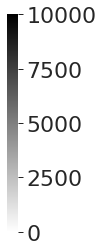

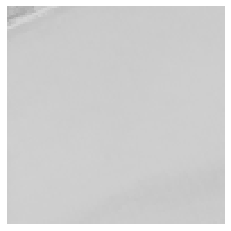

Input B8A


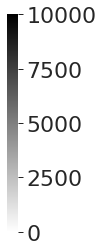

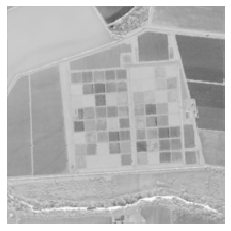

Ground truth


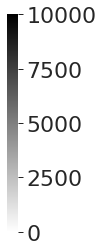

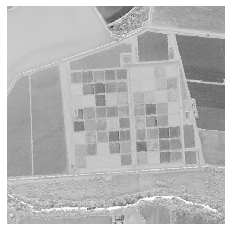

Input zoom


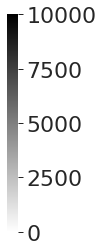

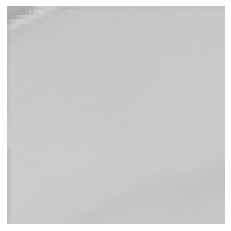

Ground truth zoom


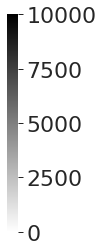

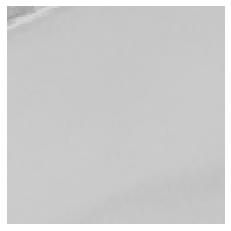

B8A S2Sharp


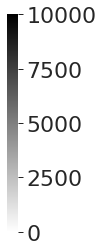

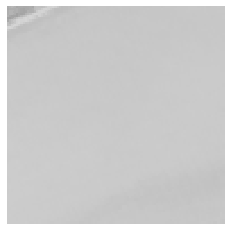

B8A SSC


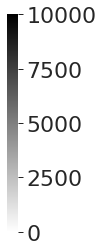

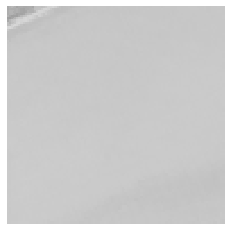

Input B9


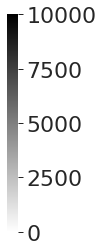

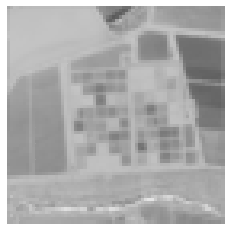

Ground truth


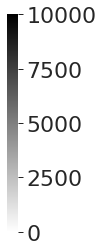

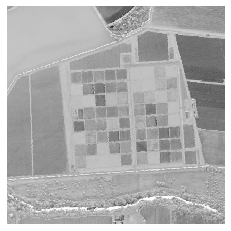

Input zoom


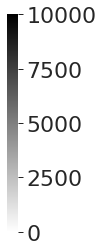

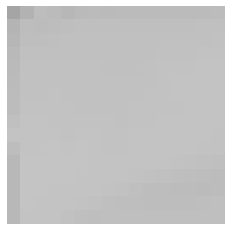

Ground truth zoom


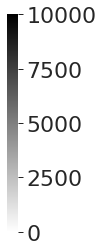

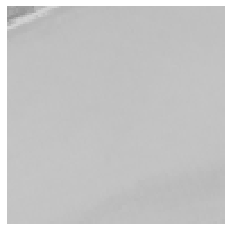

B9 S2Sharp


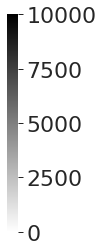

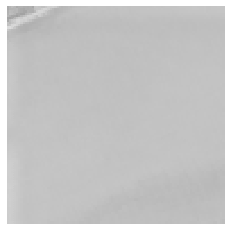

B9 SSC
NaN
Input B11


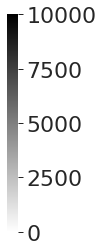

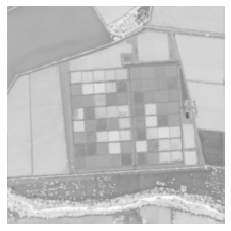

Ground truth


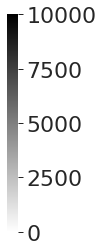

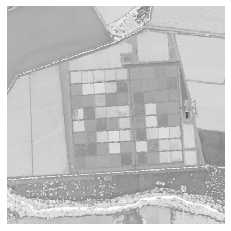

Input zoom


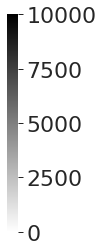

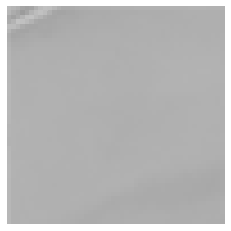

Ground truth zoom


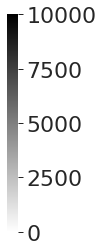

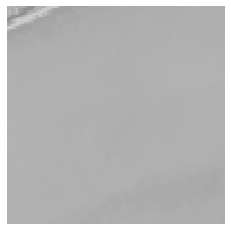

B11 S2Sharp


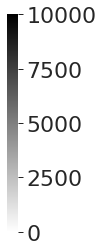

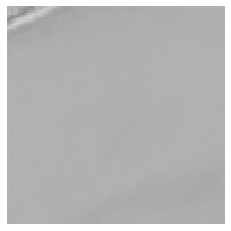

B11 SSC


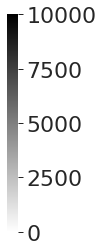

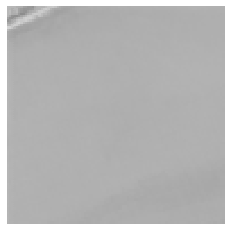

Input B12


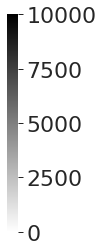

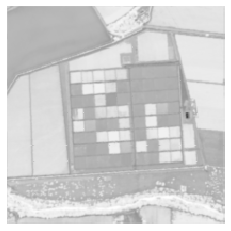

Ground truth


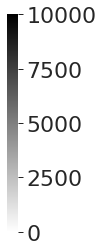

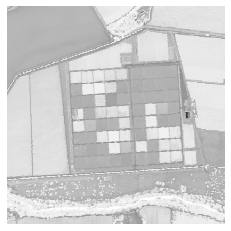

Input zoom


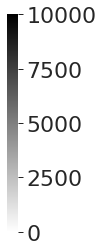

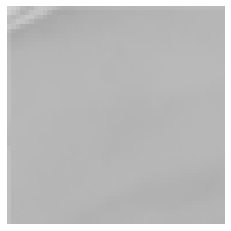

Ground truth zoom


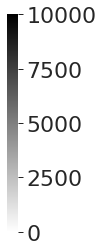

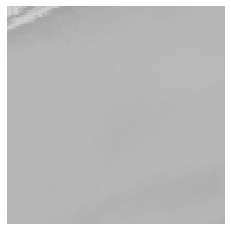

B12 S2Sharp


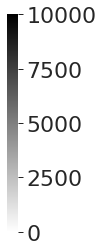

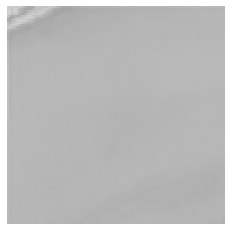

B12 SSC


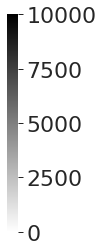

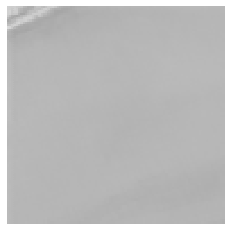

In [14]:
clip=10000
cmap='gray_r'
for dataset in data_list:
    imdir = result_dir + '/' + dataset + '/images/'
    for band in ['B1', 'B5', 'B6', 'B7', 'B8A', 'B9', 'B11', 'B12']:
        os.makedirs(imdir + band, exist_ok = True)
        
        print('Input', band)
        cbar_fig, cbar_ax = plt.subplots()
        fig, ax = plt.subplots()
        cbar_fig.set_figwidth(fig.get_figwidth()/30)
        sns_plot = sns.heatmap(Yims[dataset][band_idxs[band]][:,:],
                    xticklabels=False, yticklabels=False, vmin=0, vmax=clip,
                    square=True, cmap=cmap, ax=ax, cbar_ax=cbar_ax)
        plt.grid(False)
        fig.savefig(imdir + band + '/input_f.png', bbox_inches='tight')
        cbar_fig.savefig(imdir + band + '/input_f_cbar.png', bbox_inches='tight')
        plt.show()
        plt.close(fig)
        plt.close(cbar_fig)

        print('Ground truth')
        if np.isnan(Xm_ims[dataset][:,:,band_idxs[band]]).any():
            print('NaN')
        else:
            cbar_fig, cbar_ax = plt.subplots()
            fig, ax = plt.subplots()
            cbar_fig.set_figwidth(fig.get_figwidth()/30)
            sns_plot = sns.heatmap(Xm_ims[dataset][:,:,band_idxs[band]],
                        xticklabels=False, yticklabels=False, vmin=0, vmax=clip,
                        square=True, cmap=cmap, ax=ax, cbar_ax=cbar_ax)
            plt.grid(False)
            fig.savefig(imdir + band + '/gt_f.png', bbox_inches='tight')
            cbar_fig.savefig(imdir + band + '/gt_f_cbar.png', bbox_inches='tight')
            plt.show()
            plt.close(fig)
            plt.close(cbar_fig)

        print('Input zoom')
        cbar_fig, cbar_ax = plt.subplots()
        fig, ax = plt.subplots()
        cbar_fig.set_figwidth(fig.get_figwidth()/30)
        z = 16 if band in ['B1', 'B9'] else 48
        sns_plot = sns.heatmap(Yims[dataset][band_idxs[band]][:z,:z],
                    xticklabels=False, yticklabels=False, vmin=0, vmax=clip,
                    square=True, cmap=cmap, ax=ax, cbar_ax=cbar_ax)
        plt.grid(False)
        fig.savefig(imdir + band + '/input_z.png', bbox_inches='tight')
        cbar_fig.savefig(imdir + band + '/input_z_cbar.png', bbox_inches='tight')
        plt.show()
        plt.close(fig)
        plt.close(cbar_fig)

        print('Ground truth zoom')
        if np.isnan(Xm_ims[dataset][:96,:96,band_idxs[band]]).any():
            print('NaN')
        else:
            cbar_fig, cbar_ax = plt.subplots()
            fig, ax = plt.subplots()
            cbar_fig.set_figwidth(fig.get_figwidth()/30)
            sns_plot = sns.heatmap(Xm_ims[dataset][:96,:96,band_idxs[band]],
                        xticklabels=False, yticklabels=False, vmin=0, vmax=clip,
                        square=True, cmap=cmap, ax=ax, cbar_ax=cbar_ax)
            plt.grid(False)
            fig.savefig(imdir + band + '/gt_z.png', bbox_inches='tight')
            cbar_fig.savefig(imdir + band + '/gt_z_cbar.png', bbox_inches='tight')
            plt.show()
            plt.close(fig)
            plt.close(cbar_fig)
        for method, Xhat_im in Xhats[dataset].items():
            print(band, method)
            if np.isnan(Xhat_im[:96,:96,band_idxs[band]]).any():
                print('NaN')
            else:
                cbar_fig, cbar_ax = plt.subplots()
                fig, ax = plt.subplots()
                cbar_fig.set_figwidth(fig.get_figwidth()/30)
                sns_plot = sns.heatmap(np.maximum(0,Xhat_im[:96,:96,band_idxs[band]]),
                            xticklabels=False, yticklabels=False, vmin=0, vmax=clip,
                            square=True, cmap=cmap, cbar_ax=cbar_ax, ax=ax)
                plt.grid(False)
                fig.savefig(imdir + band + '/' + method + '_z.png', bbox_inches='tight')
                cbar_fig.savefig(imdir + band + '/' + method + '_z_cbar.png', bbox_inches='tight')
                plt.show()
                plt.close(fig)
                plt.close(cbar_fig)

In [15]:
def highlight_min(data):
    attr = 'color: red'

    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else: 
        is_min = data.groupby(level=0).transform('min') == data
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)
def highlight_max(data):
    attr = 'color: red'

    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else: 
        is_max = data.groupby(level=0).transform('max') == data
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
    
def bold_formatter(x, value, num_decimals=4):
    """Format a number in bold when (almost) identical to a given value.
    
    Args:
        x: Input number.
        
        value: Value to compare x with.
        
        num_decimals: Number of decimals to use for output format.

    Returns:
        String converted output.

    """
    # Consider values equal, when rounded results are equal
    # otherwise, it may look surprising in the table where they seem identical
    if round(x, num_decimals) == round(value, num_decimals):
        return f"\\bfseries  {x:.{num_decimals}f}"
    else:
        if np.isnan(x): return '{--}'
        else: return f"{x:.{num_decimals}f}"


def make_bfseries(x):
        return f"\\bfseries {x:.2f}"

In [16]:
for key, eval_df in eval_dfs.items():
    print(key)
    styled_df = eval_df.T.loc[slice(None), (['RMSE','SAM','ERGAS'], slice(None))].T.style.apply(highlight_min, axis=1)
    display(styled_df)
    styled_df = eval_df.T.loc[slice(None), (['SRE'], slice(None))].T.style.apply(highlight_max, axis=1)
    display(styled_df)
    styled_df = eval_df.T.loc[slice(None), (['SSIM'], slice(None))].T.style.apply(highlight_max, axis=1)
    display(styled_df)
    styled_df = eval_df.T.loc[slice(None), (['UIQI'], slice(None))].T.style.apply(highlight_max, axis=1)
    display(styled_df)
    for metric in [['UIQI'],['SSIM'],['SRE'],['RMSE','SAM','ERGAS']]:
        styled_df = eval_df.T.loc[slice(None), (metric, slice(None))]

        styled_keys = styled_df.keys()
        min_columns_2f = [k for k in styled_keys if 'ERGAS' in k or 'RMSE' in k or 'SAM' in k]
        max_columns_2f = [k for k in styled_keys if 'UIQI' in k or 'SSIM' in k or 'SRE' in k]

        fmts_max_2f = {column: partial(bold_formatter, value=styled_df[column].max(), num_decimals=2) for column in max_columns_2f}
        fmts_min_2f = {column: partial(bold_formatter, value=styled_df[column].min(), num_decimals=2) for column in min_columns_2f}

        fmts = {**fmts_max_2f, **fmts_min_2f}
        for k in styled_df.columns.values:
            if k in fmts:
                styled_df[k] = styled_df[k].apply(fmts[k])
        os.makedirs(os.path.dirname(result_dir + "/" + key + "/"), exist_ok=True)
        with open(result_dir + "/" + key + "/" + metric[0] + ".tex", "w") as fh:
            styled_df.T.to_latex(buf=fh,
                               na_rep = '--',
                               multicolumn=False,
                               index_names=True,
                               escape=False)

escondido


aviris
